In [1]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
from nltk.tree import Tree, ParentedTree
import nltk
import re

In [165]:
grammar = {}
lexicon = {}
#grammar_chomsky = {}

def is_not_POS(x, phrase):
    t = Tree.fromstring(phrase)
    return x in t.leaves()

def remove_leaf(p):
    t = Tree.fromstring(p)
    for w in t.leaves():
        p = p.replace(" " + w, "")
    return p

def remove_function(p):
    """
    :param p: string
    :return: string without functional tags
    """
    return re.sub(r'-[^ ]*', "", p)

def deal_with_P(p):
    return remove_function(remove_leaf(p[2: -1]))

def parcour_tree(t):
    for child in t:
        l.append([t.label(), child.label()])
        parcour_tree(child)
        
def parcour_tree_fin(t):
    """
    :param t: binarized tree
    :return: fill grammar and lexicon in place
    """
    lab_cur = remove_function(t.label())
    if isinstance(t[0], str):
        lexicon[t[0]] = lexicon.get(t[0], {})
        lexicon[t[0]][lab_cur] = lexicon[t[0]].get(lab_cur, 0) + 1
        #lexicon.append([remove_function(t.label()), t[0]])
    else:
        child_t = []
        for child in t:
            child_t.append(remove_function(child.label()))
        child_t = tuple(child_t)
        grammar[lab_cur] = grammar.get(lab_cur, {})
        grammar[lab_cur][child_t] =  grammar[lab_cur].get(child_t, 0)+1
        for child in t:
            parcour_tree_fin(child)
            
"""           
count = [0]
storage = {}
""" 

def binarize_tree(t):
    """
    :param t: tree
    :return: binarized tree with new nodes
    """
    #child = [binarize_tree(child)]
    if isinstance(t[0], str):
        return t
    if len(t)<=2:
        return Tree(t.label(), [binarize_tree(child) for child in t])
    else:
        new_pos = ''
        for child in t[1:]:
            new_pos = new_pos+'|'+child.label()
        new_pos = new_pos[1:]
        return Tree(t.label(), [binarize_tree(t[0]), Tree(new_pos, [binarize_tree(child) for child in t[1:]])])

def remove_function_tree(t):
    if not isinstance(t, str):
        return Tree(remove_function(t.label()), [remove_function_tree(child) for child in t])
    return t

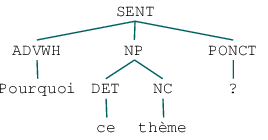

In [615]:
t = Tree.fromstring("(SENT (ADVWH Pourquoi) (NP (DET ce) (NC thème)) (PONCT ?))")
t

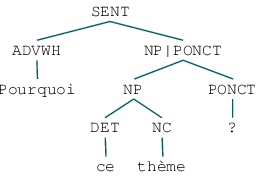

In [616]:
#sanity check
binarize_tree(t)

In [166]:
# Chomsky's grammar

def normalize_grammar(g):
    """
    :param g: grammar (dict of dict of count)
    :return: normalized grammar (dict of dict of probability)
    """
    for pos in g.keys():
        count = sum(g[pos].values())
        for key in g[pos].keys():
            g[pos][key] /= count
    return g

#sanity check
#print(grammar)
#normalize_grammar(grammar)

In [167]:
# Load dataset
#there are 3099 lines in the whole dataset

#fill the path
filepath = '/Users/anneabeille/Documents/MVA/Speech/parser/sequoia-corpus+fct.mrg_strict' 

with open(filepath, encoding='utf-8') as input_file:
    lines=input_file.readlines()
    train = lines[int(len(lines)*0.1):int(len(lines)*0.9)]
    test = lines[int(len(lines)*0.9):]
    val = lines[:int(len(lines)*0.1)]
    
grammar = {}
lexicon = {}

In [169]:
for line in train:
    t = Tree.fromstring(line[2: -2])
    t = binarize_tree(t)
    parcour_tree_fin(t)
    
grammar = normalize_grammar(grammar)

In [170]:
#nombre de règles de la grammaire

number_rules=0
number_unit_rules = 0
for pos in grammar:
    number_rules += len(grammar[pos])
    for key in grammar[pos]:
        if len(key)==1:
            number_unit_rules += 1
print(number_rules)
print(number_unit_rules)

3749
39


In [380]:
def remove_unit_grammar(grammar):
    still_unit = False
    for pos in grammar:
        for key in list(grammar[pos]):
            if len(key)==1:
                proba = grammar[pos].pop(key)
                for new_key in list(grammar.get(key[0], {})):
                    grammar[pos][new_key] = grammar[pos].get(new_key, 0)
                    grammar[pos][new_key] = grammar[pos][new_key] + proba*grammar[key[0]][new_key]
                still_unit = True
    return grammar, still_unit

In [386]:
still_unit_in_g = True
while still_unit_in_g:
    grammar, still_unit_in_g = remove_unit_grammar(grammar)

#need to renormalize
grammar = normalize_grammar(grammar)

In [387]:
print(bool)
#nombre de règles de la grammaire

number_rules=0
number_unit_rules = 0
for pos in grammar:
    number_rules += len(grammar[pos])
    for key in grammar[pos]:
        if len(key)==1:
            number_unit_rules += 1

print(number_rules)

#sanity check
print(number_unit_rules)

False
7929
0


In [228]:
def invert_grammar(g):
    g_inv = {}
    for w, dic in g.items():
        for pos, number in dic.items():
            g_inv[pos] = g_inv.get(pos, {})
            g_inv[pos][w] = number
    return g_inv

lexicon_inv = invert_grammar(lexicon)        
lexicon_inv = normalize_grammar(lexicon_inv)
lexicon_norm = invert_grammar(lexicon_inv)
grammar_inv = invert_grammar(grammar)

In [258]:
### CYK ###
def first_non_terminaux_from_words(s):
    non_term_list = []
    for w in s:
        wdic = lexicon_norm[w]
        nwdic = {k:[v] for (k, v) in wdic.items()}
        add_every_unary(nwdic)
        sum_norm = sum(val[0] for val in nwdic.values())
        for pos in nwdic.keys():
            nwdic[pos][0] = nwdic[pos][0]/sum_norm 
        non_term_list.append(nwdic)
    return non_term_list

def generate_couple(j, i):
    return [[k, i, j-1-k, i+1+k] for k in range(j)]

def iter_cyk(wlistlist):
    pos_list = []
    for i in range(len(wlistlist[-1])-1):
        liste_couple = generate_couple(len(wlistlist), i)
        new_dic = {}
        for couple in liste_couple:
            dic_g = wlistlist[couple[0]][couple[1]]
            dic_d = wlistlist[couple[2]][couple[3]]
            for pos1, v1 in dic_g.items():
                for pos2, v2 in dic_d.items():
                    #inutile maintenant#
                    if not isinstance(v1, float):
                        v1 = v1[0]
                    if not isinstance(v2, float):
                        v2 = v2[0]
                    ### ###
                    for pos_father, proba_trans in grammar_inv.get((pos1, pos2), {}).items():
                        current_proba = new_dic.get(pos_father, [0])[0]
                        if proba_trans*v1*v2 > current_proba:
                            #on a trouvé un meilleur chemin pour pos_father
                            new_dic[pos_father] = [proba_trans*v1*v2, pos1, pos2, couple]       
        # Handling unary rules
        add_every_unary(new_dic)
        #
        
        #on normalise pour éviter les erreurs d'arrondis
        """
        sum_norm = sum(val[0] for val in new_dic.values())
        for pos in new_dic.keys():
            new_dic[pos][0] = new_dic[pos][0]/sum_norm 
        """
        pos_list.append(new_dic)
        
    return pos_list

def cyk(s):
    l = [first_non_terminaux_from_words(s)]
    while len(l[-1])>1:
        l.append(iter_cyk(l))
    return l

def _create_sub_tree(cyk_list, pos, coordinates, s):
    if len(cyk_list[coordinates[0]][coordinates[1]][pos])==1:
        #on a atteint une feuille
        return Tree(pos, [Tree(s[coordinates[1]], [])]) 
    if len(cyk_list[coordinates[0]][coordinates[1]][pos])==2:
        #unary rule
        npos = cyk_list[coordinates[0]][coordinates[1]][pos][1]
        return Tree(pos, [_create_sub_tree(cyk_list, npos, coordinates, s)]) 
    pos1 = cyk_list[coordinates[0]][coordinates[1]][pos][1]
    pos2 = cyk_list[coordinates[0]][coordinates[1]][pos][2]
    coordinates1 = cyk_list[coordinates[0]][coordinates[1]][pos][3][:2]
    coordinates2 = cyk_list[coordinates[0]][coordinates[1]][pos][3][2:]
    return Tree(pos, [_create_sub_tree(cyk_list, pos1, coordinates1, s), _create_sub_tree(cyk_list, pos2, coordinates2, s)])

def _tree_from_cyk(cyk_list, s): 
    if cyk_list[-1][0].get('SENT', [0])[0] == 0:
        print("The sentence is not in the grammar")
        return Tree('not', [Tree('in', []), Tree('grammar', [])])
    else:
        return _create_sub_tree(cyk_list, 'SENT', [len(cyk_list)-1, 0], s)

def tree_from_sentence(s):
    return _tree_from_cyk(cyk(s), s)

In [259]:
### CYK with unary rules : possible to recover the "real" tree

def _add_unary_tab_once(dico):
    still_unit = False
    for pos_from in list(dico.keys()):
        pos_from = (pos_from,)
        for pos_to in list(grammar_inv.get(pos_from, {})):
            if grammar[pos_to][pos_from]*dico[pos_from[0]][0] > dico.get(pos_to, [0])[0]:
                dico[pos_to] = [grammar[pos_to][pos_from]*dico[pos_from[0]][0], pos_from[0]]
                still_unit = True
    return still_unit

def add_every_unary(dico):
    again = True
    while again:
        again = _add_unary_tab_once(dico)
        
def debinarize(t):
    """
    :param t: binary tree with made-up nodes
    :return: "true" binary tree, with nodes in the initial grammar
    """
    if len(t[0])==0: #leaf
        return t
    if len(t)==1: #une branche
        return Tree(t.label(), [debinarize(t[0])])
    if "|" in t[1].label(): #symbol in grammar
        right_child = debinarize(t[1])
        return Tree(t.label(), [debinarize(t[0])] + [great_child for great_child in right_child ])
    return Tree(t.label(), [debinarize(t[0])] + [debinarize(t[1])])

def bracket_to_list(b):
    return Tree.fromstring(b).leaves()

def tree_to_string(tree):
    if len(tree)==0:
        return tree.label()
    if isinstance(tree, str):
        return tree
    else:
        l = [tree_to_string(child) for child in tree]
        s = '(' + tree.label() + ' '
        for lc in l:
            s = s + lc
        s = s + ')'
        return s

In [14]:
s2 = "( (SENT (VPinf (VN (VINF Lire)) (NP-OBJ (DET la) (NC notice)) (PP-MOD (P avant) (NP (NC usage)))) (PONCT .)))"
t = Tree.fromstring(s2)
t2 = remove_function_tree(t)

In [20]:
t2.draw()

KeyboardInterrupt: 

In [22]:
debinarize(tree_from_sentence(bracket_to_list(s2))).draw()

KeyboardInterrupt: 

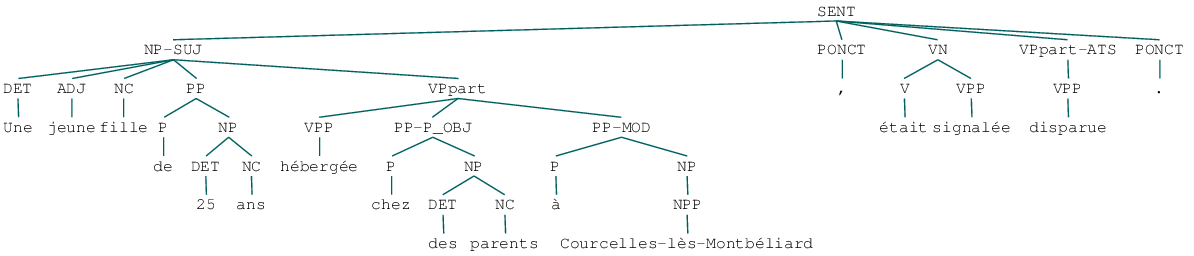

In [185]:
Tree.fromstring(train[68][2:-2])

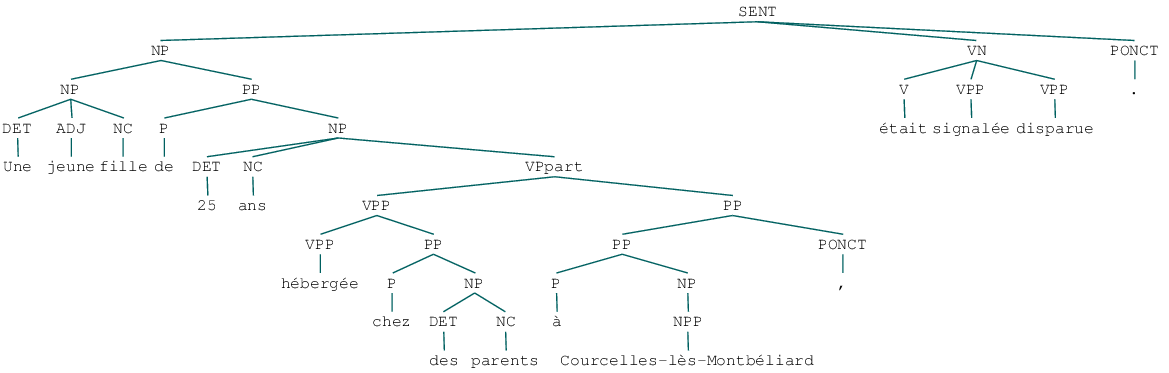

In [187]:
debinarize(tree_from_sentence(bracket_to_list(train[68][2:-2])))

In [17]:
tree_from_sentence(["les", "élus", "votent", "."])

LookupError: 

===========================================================================
NLTK was unable to find the gs file!
Use software specific configuration paramaters or set the PATH environment variable.
===========================================================================

Tree('SENT', [Tree('NP', [Tree('DET', [Tree('les', [])]), Tree('NC', [Tree('élus', [])])]), Tree('VN|PONCT', [Tree('VN', [Tree('V', [Tree('votent', [])])]), Tree('PONCT', [Tree('.', [])])])])

NP
VN|PONCT
[1, 0]
[3, 2]
DET
NC
[0, 0]
[0, 1]
VN
PONCT
[2, 2]
[0, 5]
V
NP
[0, 2]
[1, 3]
DET
NC
[0, 3]
[0, 4]


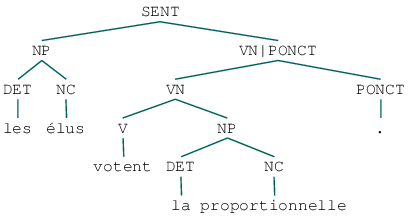

In [506]:
tree_from_cyk(cyk(["les", "élus", "votent", 'la', "proportionnelle", "."]), ["les", "élus", "votent", 'la', "proportionnelle", "."])

In [32]:
sent = """(SENT (NP (NPP Paris) (PONCT ,) (NP-MOD (NC ville) (PP (P de) (NP (NC lumière))))) (PONCT !))"""

In [33]:
sentn = bracket_to_list(sent)

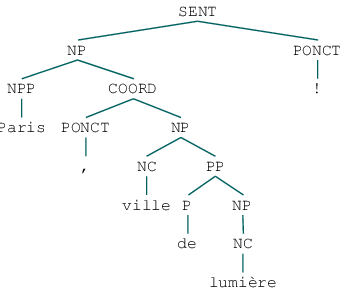

In [35]:
debinarize(tree_from_sentence(sentn))

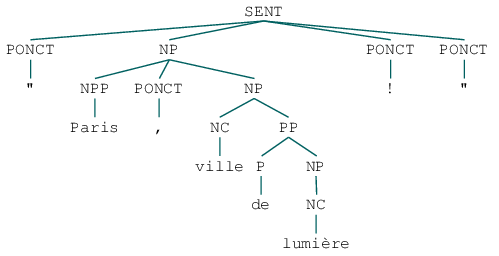

In [11]:
remove_function_tree(Tree.fromstring(sent))

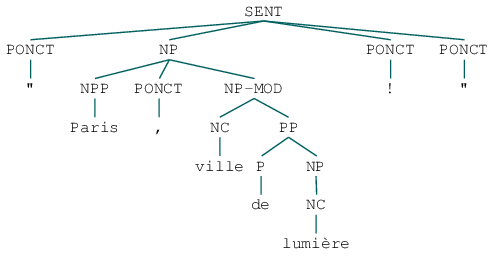

In [14]:
Tree.fromstring(sent)

NP
NP|PONCT
[2, 0]
[4, 3]
PONCT
NPP|PONCT
[0, 0]
[1, 1]
NPP
PONCT
[0, 1]
[0, 2]
NP
PONCT
[3, 3]
[0, 7]
NC
PP
[0, 3]
[2, 4]
P
NP
[0, 4]
[1, 5]
NC
PONCT
[0, 5]
[0, 6]


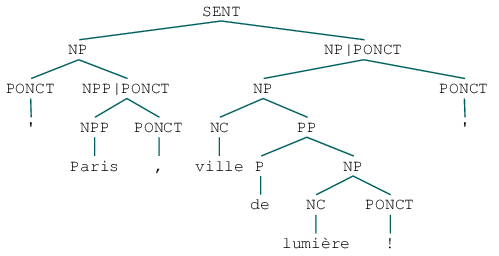

In [523]:
tree_from_sentence(sent_n)

In [36]:
s = "( (SENT (VPinf (VN (VINF Lire)) (NP-OBJ (DET la) (NC notice)) (PP-MOD (P avant) (NP (NC usage)))) (PONCT .)))"
T = Tree.fromstring(s)

In [56]:
str(T).replace('\n ', '')

'( (SENT   (VPinf     (VN (VINF Lire))     (NP-OBJ (DET la) (NC notice))     (PP-MOD (P avant) (NP (NC usage))))   (PONCT .)))'

In [59]:
Tree('aze', [])

In [141]:
# OOV

In [116]:
s2

'(SENT (NP-SUJ (DET Les) (NC enfants)) (VN (V fêtent)) (NP-OBJ (NC saint) (NPP Honoré)))'

In [142]:
tree_to_string(T.fromstring(s2))

'(SENT (NP-SUJ (DET Les)(NC enfants))(VN (V fêtent))(NP-OBJ (NC saint)(NPP Honoré)))'

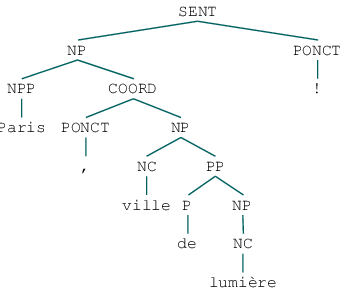

In [114]:
Tree.fromstring(tree_to_string(debinarize(tree_from_sentence(sentn))))

In [541]:
grammar = normalize_grammar(grammar)
still_unit_in_g = True
while still_unit_in_g:
    grammar, still_unit_in_g = remove_unit_grammar(grammar)

#need to renormalize
grammar = normalize_grammar(grammar)

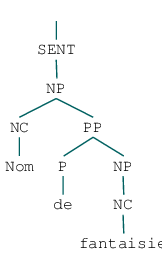

In [619]:
Tree.fromstring("( (SENT (NP (NC Nom) (PP (P de) (NP (NC fantaisie))))))")

NC
PP
[0, 0]
[1, 1]
P
NP
[0, 1]
[0, 2]


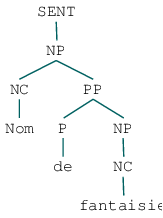

In [632]:
tree_from_sentence(["Nom", "de", "fantaisie"])

In [623]:
cyk(["Nom", "de", "fantaisie"])

[[{'NC': [0.00016554920950252462],
   'SENT': [2.6258564712812928e-06, 'NP'],
   'NP': [2.2301794687594544e-05, 'NC'],
   'AP': [5.559073522583097e-08, 'NC'],
   'PP': [1.3651931126098523e-08, 'NP'],
   'COORD': [1.4141911659857034e-08, 'NP']},
  {'DET': [0.006874241811564901],
   'P': [0.34069178852643417],
   'NP': [4.577639882509756e-07, 'DET'],
   'PP': [0.00029197386382040144, 'P'],
   'SENT': [4.7092558680709913e-07, 'PP'],
   'COORD': [2.9027519863727053e-10, 'NP']},
  {'NC': [8.277460475126231e-05],
   'SENT': [1.3129282356406464e-06, 'NP'],
   'NP': [1.1150897343797272e-05, 'NC'],
   'AP': [2.7795367612915485e-08, 'NC'],
   'PP': [6.825965563049261e-09, 'NP'],
   'COORD': [7.070955829928517e-09, 'NP']}],
 [{'NP': [0.0428572881766297, 'NC', 'PP', [0, 0, 0, 1]],
   'NC|NP': [0.0012903239611752766, 'NC', 'NP', [0, 0, 0, 1]],
   'NC|PP': [0.82300242525377, 'NC', 'PP', [0, 0, 0, 1]],
   'NC|COORD': [8.182143063888883e-07, 'NC', 'COORD', [0, 0, 0, 1]],
   'PP': [0.01583856302179793,

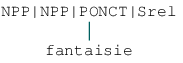

In [622]:
Tree(pos, _create_sub_tree(cyk(["Nom", "de", "fantaisie"]), 'NP', [0, 2], ["Nom", "de", "fantaisie"]))

In [625]:
cyk(["Nom", "de", "fantaisie"])[0][2]['NP'][1]

'NC'

{'Amélioration': {'NC': 1}, 'de': {'P': 1}, 'la': {'DET': 1}, 'sécurité': {'NC': 1}, 'Pourquoi': {'ADVWH': 1}, 'ce': {'DET': 1}, 'thème': {'NC': 1}, '?': {'PONCT': 1}}
{'SENT': {('NP',): 1, ('ADVWH', 'NP', 'PONCT'): 1}, 'NP': {('NC', 'PP'): 1, ('DET', 'NC'): 2}, 'PP': {('P', 'NP'): 1}}


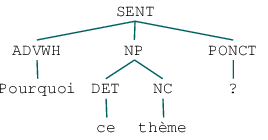

In [339]:
#sanity check
s = "( (SENT (NP (NC Amélioration) (PP (P de) (NP (DET la) (NC sécurité))))))"
s2 = "( (SENT (ADVWH Pourquoi) (NP (DET ce) (NC thème)) (PONCT ?)))"
s3 = "( (SENT (NP (NC Espoir))))"
S = '( (SENT (NP-SUJ (DET Cette) (NC exposition)) (VN (CLO-A_OBJ nous) (V apprend)) (Ssub-OBJ (CS que) (PP-MOD (P dès) (NP (DET le) (ADJ XIIe) (NC siècle))) (PONCT ,) (PP-MOD (P à) (NP (NPP Dammarie-sur-Saulx))) (PONCT ,) (PP-MOD (P entre) (NP (ADJ autres) (NC sites))) (PONCT ,) (NP-SUJ (DET une) (NC industrie) (AP (ADJ métallurgique))) (VN (V existait))) (PONCT .)))'
t = Tree.fromstring(s2[2: -1])
parcour_tree_fin(t)
print(lexicon)
print(grammar)
t

In [24]:
Tree.fromstring("( (SENT (NP (NC Amélioration) (PP (P de) (NP (DET la) (NC sécurité))))))")

LookupError: 

===========================================================================
NLTK was unable to find the gs file!
Use software specific configuration paramaters or set the PATH environment variable.
===========================================================================

Tree('', [Tree('SENT', [Tree('NP', [Tree('NC', ['Amélioration']), Tree('PP', [Tree('P', ['de']), Tree('NP', [Tree('DET', ['la']), Tree('NC', ['sécurité'])])])])])])

In [172]:
def levenshtein(s, t, threshold=None):
    """
    d[i,j] = levenshtein(s[:i], t[:j]) 
    """
    if threshold is None:
        threshold = len(s) + len(t)
    if abs(len(s) - len(t)) > threshold:
        return threshold + 1
    nrows = len(s) + 1
    ncols = len(t) + 1
    d = [[0 for _ in range(ncols)] for _ in range(nrows)] 
    
    for i in range(len(d)):
        d[i][0] = i
    for i in range(ncols):
        d[0][i] = i
    
    for i in range (1, nrows):
        for j in range(1, ncols):
            d[i][j] = min(d[i-1][j-1] + (s[i-1] != t[j-1]), d[i-1][j] + 1, d[i][j-1] + 1)
    return d[-1][-1]

In [173]:
import pickle
import numpy as np
from operator import itemgetter


def cosine_nearest(embeddings, word, k=1):
    """Returns the k nearest words"""
    word_index = word_id[word]
    e = embeddings[word_index]
    distances = np.dot(embeddings, e)
    sorted_distances = sorted(enumerate(distances), key=itemgetter(1), reverse=True)
    return ([id_word[sorted_distances[i][0]] for i in range(1, k+1)], 
            [sorted_distances[i][1] for i in range(1, k+1)])
    


file = open('polyglot-fr.pkl', 'rb')
words, embeddings = pickle.load(file, encoding='latin1')

# Map words to indices and vice versa
word_id = {w:i for (i, w) in enumerate(words)}
id_word = dict(enumerate(words))

# Normalise embeddings
norms = np.linalg.norm(embeddings, axis=1)
embeddings = embeddings / norms[:, None]

print(cosine_nearest(embeddings, "Paris"))

(['Bordeaux'], [0.88492876])


In [196]:
indices = {}
for i, w in enumerate(words):
    l = len(w)
    if l not in indices:
        indices[l] = [i]   
    else:
        indices[l].append(i)
        
def find_near(word, k):
    res = []
    l = len(word)
    for i in range(l-k, l+k+1):
        if not indices[i]:
            continue
        for index in indices[i]:
            w = words[index]
            if levenshtein(w, word, k) <= k:
                res.append(w)
    return res

"""
def find_near(word, k):
    res = []
    for w in words:
        if levenshtein(w, word) <= k:
            res.append(w)
    return res
"""

def _create_from_lex(word, wnear, weight=1):
    for pos, count in lexicon.get(wnear, {}).items():
        lexicon[word] = lexicon.get(word, {})
        lexicon[word][pos] = lexicon[word].get(pos, 0) + weight*count

def create_lex_entry(word, indice_sentence=1, k_lev=1, d_emb=5):
    if indice_sentence>0 and (word[0].upper() == word[0]) and (word[0].lower() != word[0]):
        lexicon[word] = {'NPP':1, 'ADJ':0.05, 'NC':0.05}
        #print('a')
        #print(lexicon[word])
        
    elif '_' in word:
        lexicon[word] = {'P': 341, 'PRO': 29, 'ADV': 336, 'DET': 102,'CS': 97,
                             'CC': 36,'P+D': 98,'V': 7,'ADJ': 5,'ET': 1,'CLS': 9,'NC': 4}  
    else:
        near_word_lev = find_near(word, k_lev)
        for w in near_word_lev:
            if w in lexicon:
                _create_from_lex(word, w)
            else:
                w_emb_list, w_weight_list = cosine_nearest(embeddings, w, d_emb)
                for index, w_emb in enumerate(w_emb_list):
                    _create_from_lex(word, w_emb, w_weight_list[index])
    if word not in lexicon: #not a clue of what it might be
        lexicon[word] = {'NC':1/3, 'ADJ': 1/3, 'V' : 1/3}

In [119]:
lexicon_tiret = {}
for w in lexicon:
    if '_' in w:
        for key, value in lexicon[w].items():
            lexicon_tiret[key] = lexicon_tiret.get(key, 0) + value

In [120]:
lexicon_tiret

{'P': 341,
 'PRO': 29,
 'ADV': 336,
 'DET': 102,
 'CS': 97,
 'CC': 36,
 'P+D': 98,
 'V': 7,
 'ADJ': 5,
 'ET': 1,
 'CLS': 9,
 'NC': 4}

In [251]:
for nline, line in enumerate(test[103:113]):
    wlist = bracket_to_list(line)
    print(wlist)

['Catégories', ':', 'Affaire', 'politico-', 'financière', 'française', '.']
['Affaire', 'des', 'marchés', 'publics', "d'", 'Ile-de-France', '.']
['Financement', 'illégal', 'du', 'RPR']
['Affaire', 'des', 'matches', 'truqués', 'du', 'Calcio']
["L'", 'affaire', 'des', 'matches', 'truqués', 'du', 'Calcio', '-LRB-', 'aussi', 'appelé', 'Calciopoli', ',', 'voire', 'Moggiopoli', 'pour', 'la', 'presse', 'hostile', 'à', 'la', 'Juventus', ',', 'du', 'nom', 'de', 'Luciano', 'Moggi', '-RRB-', 'est', 'un', 'scandale', 'sportivo-', 'financier', 'secouant', 'en', '2006', 'le', 'championnat', 'de', 'football', 'italien', '.']
['Plusieurs', 'clubs', 'sont', 'accusés', "d'", 'avoir', 'influencé', 'la', 'désignation', 'des', 'arbitres', 'pour', 'leurs', 'matches', '.']
['Le', 'scandale', 'des', 'matches', 'truqués']
['Au', 'printemps', '2006', ',', 'le', 'scandale', 'éclate', 'suite_à', 'la', 'publication', 'dans', 'la', 'presse', 'italienne', '-LRB-', 'La', 'Gazzetta', 'dello', 'Sport', 'et', 'Il', 'Cor

In [93]:
brack = ["L'", 'affaire', 'des', 'matches', 'truqués', 'du', 'Calcio', '-LRB-', 'aussi', 'appelé', 'Calciopoli', ',', 'voire', 'Moggiopoli', 'pour', 'la', 'presse', 'hostile', 'à', 'la', 'Juventus', ',', 'du', 'nom', 'de', 'Luciano', 'Moggi', '-RRB-', 'est', 'un', 'scandale', 'sportivo-', 'financier', 'secouant', 'en', '2006', 'le', 'championnat', 'de', 'football', 'italien', '.']
for i, w in enumerate(brack):
    if w not in lexicon:
        create_lex_entry(w, indice_sentence=i, lexicon_val = lexicon_val)
        #print(lexicon_val[w], w)

In [193]:
#lexicon_val = {}

def predicted_label(w):
    return max(lexicon[w], key=lexicon[w].get)

def evaluate_oov():
    success = 0
    non_failure = 0
    word_tried = 0
    for nline, line in enumerate(val[:20]):
        wlist = bracket_to_list(line)
        t = Tree.fromstring(line)
        t = t.pos()
        for i, w in enumerate(wlist):
            if w not in lexicon:
                create_lex_entry(w, indice_sentence=i, lexicon_val = lexicon_val)
                success += (predicted_label(w)==t[i][1])
                non_failure += t[i][1] in lexicon[w]
                word_tried += 1
                print(success, non_failure, w, predicted_label(w), t[i][1])
    return success, non_failure, word_tried, success/word_tried, non_failure/word_tried

def extend_lexicon_with_test():
    success = 0
    non_failure = 0
    word_tried = 0
    for nline, line in enumerate(test):
        if nline%10 == 0:
            print(nline)
        wlist = bracket_to_list(line)
        t = Tree.fromstring(line)
        t = t.pos()
        for i, w in enumerate(wlist):
            if w not in lexicon:
                create_lex_entry(w, indice_sentence=i)
                success += (predicted_label(w) == t[i][1])
                non_failure += t[i][1] in lexicon[w]
                word_tried += 1
                print(success, non_failure, w, predicted_label(w), t[i][1])
    return success, non_failure, word_tried, success/word_tried, non_failure/word_tried

In [260]:
# parse one phrase

def sent_to_parse_sent(s):
    brack_s = bracket_to_list(s)
    t = tree_from_sentence(brack_s)
    t = debinarize(t)
    return tree_to_string(t)

out_file_test = open("test.txt", "w", encoding='utf-8')
for i, line in enumerate(test):
    if i%10 == 0:
        print(i)
    # write line to output file
    line = line[2:-2]
    parsing = sent_to_parse_sent(line)
    out_file_test.write(parsing)
    out_file_test.write("\n")
out_file_test.close()

0


10


20


30


40


50


60


70


80


90


100


110


The sentence is not in the grammar


120


130


140


150


160


The sentence is not in the grammar


The sentence is not in the grammar
170


The sentence is not in the grammar


180


190


200


210


220


230


240


250


260


270


280


The sentence is not in the grammar


290


300


In [276]:
out_file_truth = open("test_truth.txt", "w", encoding='utf-8')
for i, line in enumerate(test):
    if i%10 == 0:
        print(i)
    # write line to output file
    line = line[2:-2]
    t = Tree.fromstring(line)
    t = remove_function_tree(t)
    parsing = tree_to_string(t)
    out_file_truth.write(parsing)
    out_file_truth.write("\n")
out_file_truth.close()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


In [274]:
line = test[1]
line = line[2:-2]
t = Tree.fromstring(line)
t = remove_function_tree(t)
parsing = tree_to_string(t)
print(line)
parsing

(SENT (PONCT -) (NP-MOD (NC Février) (NC 2005)) (PONCT :) (NP-SUJ (DET le) (NC parquet) (PP (P de) (NP (NPP Paris)))) (VN (V requiert)) (NP-OBJ (DET un) (PREF non-) (NC lieu) (PP (P en_faveur_de) (NP (NPP Jean) (NPP Tiberi))) (PONCT ,) (VPpart (VPP accordé) (PP-P_OBJ (P par) (NP (DET le) (NC juge) (NPP Armand) (NPP Riberolles))))) (PONCT .))


'(SENT (PONCT -)(NP (NC Février)(NC 2005))(PONCT :)(NP (DET le)(NC parquet)(PP (P de)(NP (NPP Paris))))(VN (V requiert))(NP (DET un)(PREF non-)(NC lieu)(PP (P en_faveur_de)(NP (NPP Jean)(NPP Tiberi)))(PONCT ,)(VPpart (VPP accordé)(PP (P par)(NP (DET le)(NC juge)(NPP Armand)(NPP Riberolles)))))(PONCT .))'

In [241]:
s = test[1][2:-2]
brack_s = bracket_to_list(s)
print(brack_s)

['-', 'Février', '2005', ':', 'le', 'parquet', 'de', 'Paris', 'requiert', 'un', 'non-', 'lieu', 'en_faveur_de', 'Jean', 'Tiberi', ',', 'accordé', 'par', 'le', 'juge', 'Armand', 'Riberolles', '.']


In [232]:
Tree.fromstring(s).draw()

KeyboardInterrupt: 

In [235]:
s = test[1]
brack_s = bracket_to_list(s)
t = tree_from_sentence(s)
t = binarize_tree(t)
tree_to_string(t)

KeyError: '('

In [231]:
lexicon['a']

{'V': 624, 'ET': 2}

In [182]:
e = evaluate_oov()

1 1 Gutenberg NPP NPP
1 2 XIIe NPP ADJ
2 3 Dammarie-sur-Saulx NPP NPP


3 4 métallurgique ADJ ADJ


4 5 existait V V
4 6 à_peu_près P ADV
5 7 Gutenberg NPP NPP


5 8 inventait NC V


6 9 imprimerie NC NC
7 10 Gillet NPP NPP
8 11 Bonnemire NPP NPP


9 12 1450 NC NC


10 13 forge NC NC
11 14 Saint-Dizier NPP NPP


12 15 emplacement NC NC
13 16 CHS NPP NPP


14 17 installée VPP VPP


15 18 forge NC NC
16 19 Vacquerie NPP NPP


17 20 emplacement NC NC
18 21 Cora NPP NPP


19 22 1953 NC NC


20 23 hauts ADJ ADJ


21 24 fourneaux NC NC


22 25 fonderies NC NC
23 26 Cousances NPP NPP


24 27 virent V V
25 28 Baudesson NPP NPP


26 29 échevin NC NC
27 30 Saint-Dizier NPP NPP


27 30 patentes NC ADJ
28 31 Henri NPP NPP


28 32 installa VPP V
29 33 Marnaval NPP NPP


30 34 signifiait V V


30 35 val V NC


30 36 vallée ADJ NC
31 37 Marne NPP NPP
31 38 ou_bien P CC


31 38 aval NPP NC
32 39 Marne NPP NPP


33 40 forge NC NC


34 41 connut V V


35 42 apogée NC NC
35 43 Tout_au_long_des P P+D


36 44 créés VPP VPP
37 45 Haironville NPP NPP
38 46 Ancerville NPP NPP


39 47 Amélioration NC NC


40 48 invité VPP VPP


41 49 routière ADJ ADJ


42 50 automobilistes NC NC


43 51 quitté VPP VPP


43 52 chaussée ADJ NC


44 53 intersection NC NC
44 53 RD192 NPP NC


45 54 rural ADJ ADJ
46 55 Vaux NPP NPP
47 56 Fossés NPP NPP


48 57 panneau NC NC


49 58 stop NC NC


50 59 formule NC NC


51 60 usagers NC NC


51 60 délibérant ADJ VPR


51 61 accepté V VPP
52 62 DDE NPP NPP


52 62 amendes VPP NC


53 63 Espoir NC NC


54 64 remise NC NC


54 65 lavoir V NC


55 66 abrite V V


56 67 inaugurée VPP VPP
57 68 Thiriot NPP NPP
57 68 Association NPP NC


58 69 insertion NC NC
59 70 Saulx NPP NPP
60 71 Perthois NPP NPP


61 72 canton NC NC


62 73 décors NC NC


62 73 bénévoles ADJ NC
62 73 Cinq NPP DET


63 74 siècles NC NC
64 75 Ancerville NPP NPP
65 76 Thiriot NPP NPP


66 77 abondante ADJ ADJ


67 78 forêt NC NC


68 79 fournissant VPR VPR


69 80 combustible NC NC


70 81 minerai NC NC


70 82 exploitable NC ADJ


71 83 incité VPP VPP
72 84 Saint-Dizier NPP NPP


73 85 papeteries NC NC
74 86 Jeand'Heurs NPP NPP


74 87 carrières NPP NC
75 88 Savonnières NPP NPP


75 89 lavoir V NC


75 90 étonnant NC ADJ


76 91 photos NC NC


77 92 réalisations NC NC


78 93 outils NC NC


79 94 permettront V V


80 95 situé VPP VPP
81 96 Marches NPP NPP


82 97 prédilection NC NC


83 98 invasions NC NC


84 99 labeur NC NC


84 100 durs VPP ADJ
85 101 Thiriot NPP NPP


86 102 ambition NC NC


In [307]:
with open('test.txt', encoding='utf-8') as input_file:
    test_model = input_file.readlines()
    
with open('test_truth.txt', encoding='utf-8') as input_file:
    test = input_file.readlines()

In [341]:
good_pos = 0
pos_tot = 0
pos_tot_skip = 0
not_in_gram_sent = 0

mistakes = {}

for nline, line in enumerate(test_model):
    truth = Tree.fromstring(test[nline][:-1]).pos()
    trial = Tree.fromstring(line[:-1]).pos()
    if len(truth) != len(trial):
        not_in_gram_sent += 1
        pos_tot_skip += len(truth)
    else:
        for i, couple in enumerate(Tree.fromstring(line[:-1]).pos()):
            pos_tot += 1
            pos_tot_skip += 1
            good_pos += truth[i][1] == couple[1]
            if truth[i][1] != couple[1]:
                mistakes[(truth[i][1], couple[1])] = mistakes.get((truth[i][1], couple[1]), 0) + 1
common_mistakes = [(couple, mistakes[couple]) for couple in sorted(mistakes, key=mistakes.get, reverse=True)[:5]]
            
print("Number of sentences : {:d} - Number of sentences not in grammar : {:d} - Success Ratio : {:.3f}".format(
    len(test_model), not_in_gram_sent, 1 - not_in_gram_sent/len(test_model)))
print("----POS Accuracy----")
print("-- skipping non parsed sentences --")
print("Number of POS : {:d} - Success Rate : {:.3f}".format(pos_tot, good_pos/pos_tot))
print("-- accounting for non parsed sentences --")
print("Number of POS : {:d} - Success Rate : {:.3f}".format(pos_tot_skip, good_pos/pos_tot_skip))
print("-------------------------------------------------------")
print("Common mistakes : ")
for couple in common_mistakes:
    print("True label : {:s} - Predicted label : {:s} - number : {:d}".format(
        couple[0][0], couple[0][1], couple[1]))

Number of sentences : 310 - Number of sentences not in grammar : 5 - Success Ratio : 0.984
----POS Accuracy----
skipping non parsed sentences
Number of POS : 6272 - Success Rate : 0.926
accounting for non parsed sentences
Number of POS : 6441 - Success Rate : 0.901
-------------------------------------------------------
Common mistakes : 
True label : NC - Predicted label : NPP - number : 61
True label : NC - Predicted label : ADJ - number : 49
True label : ET - Predicted label : NPP - number : 26
True label : ADJ - Predicted label : NC - number : 21
True label : NPP - Predicted label : NC - number : 17


In [339]:
[(couple, mistakes[couple]) for couple in sorted(mistakes, key=mistakes.get, reverse=True)[:5]]

[(('NC', 'NPP'), 61),
 (('NC', 'ADJ'), 49),
 (('ET', 'NPP'), 26),
 (('ADJ', 'NC'), 21),
 (('NPP', 'NC'), 17)]